# Introduction to machine learning

Coure notes are [here](https://carpentries-incubator.github.io/machine-learning-novice-python/).

## Data preparation

### Load in the data

In [2]:
import pandas as pd

# load the data
cohort = pd.read_csv('./eicu_cohort.csv')
cohort.head()

,gender,age,admissionweight,unabridgedhosplos,acutephysiologyscore,apachescore,actualhospitalmortality,heartrate,meanbp,creatinine,temperature,respiratoryrate,wbc,admissionheight
0,Male,45.0,116.0,3.0778,41,46,ALIVE,109.0,154.0,1.01,36.20,41.0,10.0,178.0
1,Male,57.0,NaN,7.6736,26,31,ALIVE,106.0,46.0,-1.00,36.30,6.0,10.1,172.7
2,Female,59.0,66.6,15.0778,56,61,ALIVE,134.0,172.0,1.03,34.80,32.0,25.5,170.2
3,Male,63.0,71.9,1.3201,77,88,EXPIRED,133.0,40.0,4.30,32.60,39.0,12.6,167.6
4,Male,67.0,104.8,1.5257,75,88,EXPIRED,31.0,133.0,0.70,36.44,31.0,11.3,182.9


### SQL Query

```sql
SELECT p.gender, SAFE_CAST(p.age as int64) as age, p.admissionweight,
       a.unabridgedhosplos, a.acutephysiologyscore, a.apachescore, a.actualhospitalmortality,
       av.heartrate, av.meanbp, av.creatinine, av.temperature, av.respiratoryrate,
       av.wbc, p.admissionheight
FROM `physionet-data.eicu_crd_demo.patient` p
INNER JOIN `physionet-data.eicu_crd_demo.apachepatientresult` a
ON p.patientunitstayid = a.patientunitstayid
INNER JOIN `physionet-data.eicu_crd_demo.apacheapsvar` av
ON p.patientunitstayid = av.patientunitstayid
WHERE apacheversion LIKE 'IVa'
```

### Data exploration

Run the line below otherwise you get a lot of `FutureWarning` messages from `tableone` when using Python 3.11.

In [25]:
# Disable FutureWarning messages
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [26]:
# !pip install tableone
from tableone import tableone

# rename columns
rename = {"unabridgedhosplos":"length of stay",
          "meanbp": "mean blood pressure",
          "wbc": "white cell count"}

# view summary characteristics
t1 = tableone(cohort, groupby="actualhospitalmortality", rename=rename)
t1

# Output to LaTeX
# print(t1.tabulate(tablefmt = "latex"))

Grouped by actualhospitalmortality                                          
                                                                      Missing       Overall         ALIVE       EXPIRED
n                                                                                       536           488            48
gender, n (%)                      Female                                   0    305 (56.9)    281 (57.6)     24 (50.0)
                                   Male                                          230 (42.9)    207 (42.4)     23 (47.9)
                                   Unknown                                          1 (0.2)                     1 (2.1)
age, mean (SD)                                                              0   63.4 (17.4)   62.2 (17.4)   75.2 (12.6)
admissionweight, mean (SD)                                                 16   81.8 (25.0)   82.3 (25.1)   77.0 (23.3)
length of stay, mean (SD)                                                   0     5.6 (6.8)     5.7 (6.7)     4.3 (7.8)
acutephysiologyscore, mean (SD)                                             0   41.7 (22.7)   38.5 (18.8)   74.3 (31.7)
apachescore, mean (SD)                                                      0   53.6 (25.1)   49.9 (21.1)   91.8 (30.5)
heartrate, mean (SD)                                                        0  101.5 (32.9)  100.3 (31.9)  113.9 (40.0)
mean blood pressure, mean (SD)                                              0   89.6 (41.5)   90.7 (40.7)   78.8 (47.6)
creatinine, mean (SD)                                                       0     0.8 (2.0)     0.8 (2.0)     1.4 (1.8)
temperature, mean (SD)                                                      0    35.6 (5.6)    35.9 (4.8)   32.9 (10.4)
respiratoryrate, mean (SD)                                                  0   27.4 (15.5)   26.8 (15.4)   33.9 (15.2)
white cell count, mean (SD)                                                 0     6.5 (7.6)     6.2 (7.1)    9.9 (11.2)
admissionheight, mean (SD)                                                  8  168.4 (14.5)  168.2 (13.6)  170.3 (21.5)
actualhospitalmortality_enc, n (%) 0                                        0    488 (91.0)   488 (100.0)              
                                   1                                               48 (9.0)                  48 (100.0)

### Encoding

In [4]:
# check current type
print(cohort.dtypes)

# convert to a categorical type
categories=['ALIVE', 'EXPIRED']
cohort['actualhospitalmortality']  = pd.Categorical(cohort['actualhospitalmortality'], categories=categories)

# add the encoded value to a new column
cohort['actualhospitalmortality_enc'] = cohort['actualhospitalmortality'].cat.codes
cohort[['actualhospitalmortality_enc','actualhospitalmortality']].head()

gender                      object
age                        float64
admissionweight            float64
unabridgedhosplos          float64
acutephysiologyscore         int64
apachescore                  int64
actualhospitalmortality     object
heartrate                  float64
meanbp                     float64
creatinine                 float64
temperature                float64
respiratoryrate            float64
wbc                        float64
admissionheight            float64
dtype: object


,actualhospitalmortality_enc,actualhospitalmortality
0,0,ALIVE
1,0,ALIVE
2,0,ALIVE
3,1,EXPIRED
4,1,EXPIRED


In [5]:
# convert to a categorical type
cohort['gender'] = pd.Categorical(cohort['gender'])
cohort['gender'] = cohort['gender'].cat.codes

### Partitioning

In [6]:
from sklearn.model_selection import train_test_split

x = cohort.drop('actualhospitalmortality', axis=1)
y = cohort['actualhospitalmortality']
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.7, random_state = 42)

### Missing data

In [7]:
# impute missing values from the training set
x_train = x_train.fillna(x_train.median())
x_test = x_test.fillna(x_train.median())

### Normalisation

In [8]:
# Define the scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Alternative is zero mean, unit variance
# Subtract mean, divide by standard deviation
# from sklearn.preprocessing import StandardScaler

# fit the scaler on the training dataset
scaler.fit(x_train)

# scale the training set
x_train = scaler.transform(x_train)

# scale the test set
x_test = scaler.transform(x_test)

## Learning

### Loss function

Text(0.5, 1.0, 'Prediction error')

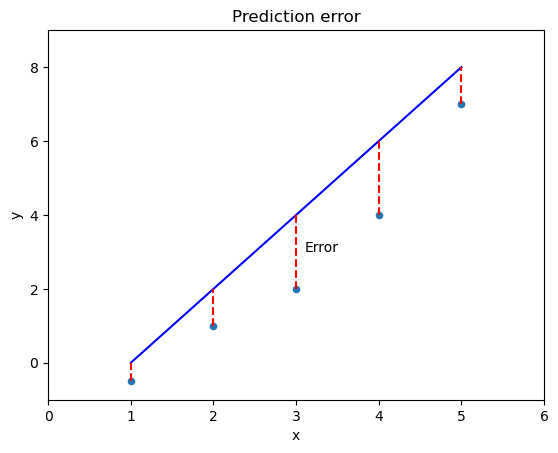

In [9]:
import pandas as pd
import matplotlib

# Create sample labelled data
data = {'x': [1, 2, 3, 4, 5], 'y': [-0.5, 1, 2, 4, 7]}
df = pd.DataFrame(data)

# Add predictions
df['y_hat'] = [0, 2, 4, 6, 8]

# plot the data
ax = df.plot(x='x', y='y', kind='scatter', xlim=[0,6], ylim=[-1,9])

# plot approx line of best fit
ax.plot(df['x'], df['y_hat'], color='blue');

# plot error
ax.vlines(x=df['x'], ymin=df['y'], ymax=df['y_hat'], color='red', linestyle='dashed')
ax.text(x=3.1, y=3, s='Error')
ax.set_title('Prediction error')

In [10]:
import numpy as np

def loss(y, y_hat):
    """
    Loss function (mean squared error).

    Args:
        y (numpy array): The known target values.
        y_hat (numpy array): The predicted values.

    Returns:
        numpy float: The mean squared error.
    """
    distances = y - y_hat
    squared_distances = np.square(distances)
    return np.mean(squared_distances)


### Minimising the error

Text(0, 0.5, 'Loss (squared error)')

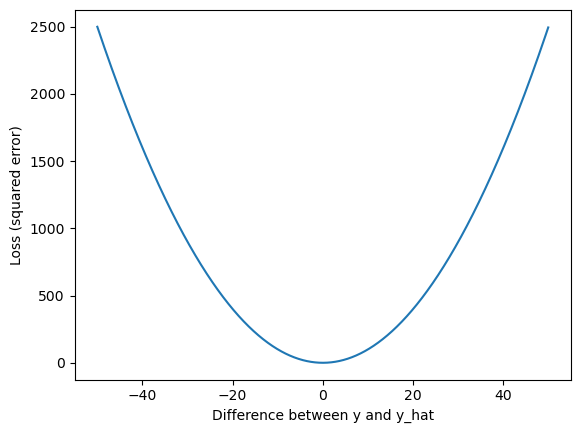

In [11]:
import matplotlib.pyplot as plt

x = np.arange(-50, 50, 0.05)
y = np.square(x)

plt.plot(x, y)
plt.xlabel('Difference between y and y_hat')
plt.ylabel('Loss (squared error)')


## Modelling

### Regression vs classification

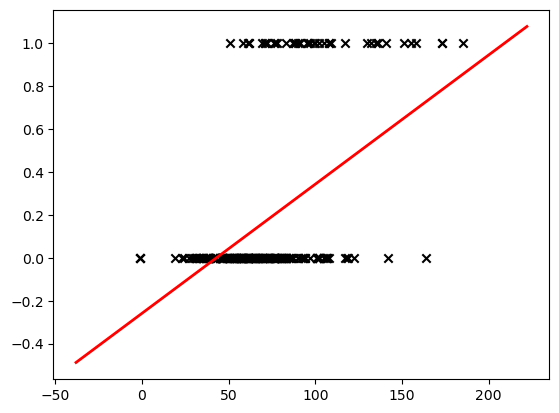

In [12]:
# import the regression model
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
reg = LinearRegression()

# use a single feature (apache score)
# note: remove the reshape if fitting to >1 input variable
X = cohort.apachescore.values.reshape(-1, 1)
y = cohort.actualhospitalmortality_enc.values

# fit the model to our data
reg = reg.fit(X, y)

# get the y values
buffer = 0.2*max(X)
X_fit = np.linspace(min(X) - buffer, max(X) + buffer, num=50)
y_fit = reg.predict(X_fit)

# plot
plt.scatter(X, y,  color='black', marker = 'x')
plt.plot(X_fit, y_fit, color='red', linewidth=2)
plt.show()

### Sigmoid function

$$f(x) = \frac{1}{(1 +e^{-x})}$$

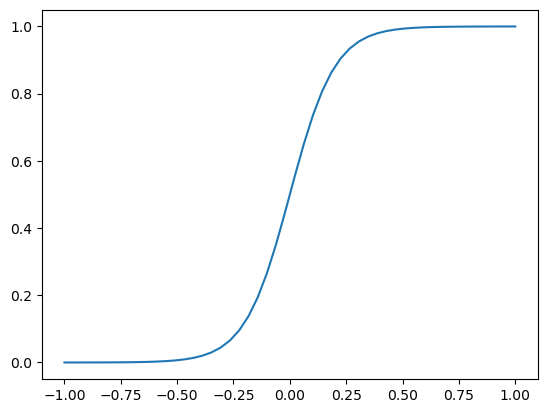

In [13]:
def sigmoid(x, k=0.1):
    """
    Sigmoid function. 
    Adjust k to set slope.
    """
    s = 1 / (1 + np.exp(-x / k)) 
    return s

# set range of values for x
x = np.linspace(-1, 1, 50)

plt.plot(x, sigmoid(x))
plt.show()

### Training (or fitting) the model

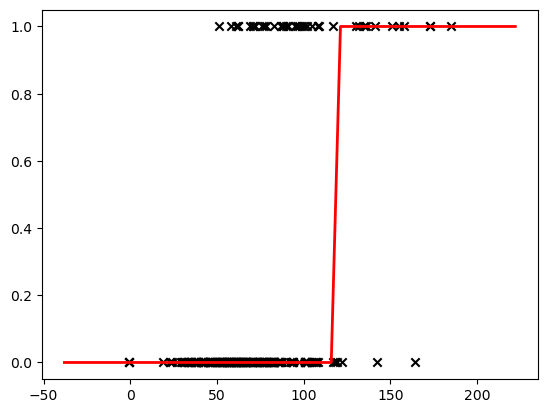

In [14]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression

reg = LogisticRegression()

# use a single feature (apache score)
# note: remove the reshape if fitting to >1 input variable
X = cohort.apachescore.values.reshape(-1, 1)
y = cohort.actualhospitalmortality_enc.values

# fit the model to our data
reg = reg.fit(X, y)

# get the y values
buffer = 0.2*max(X)
X_fit = np.linspace(min(X) - buffer, max(X) + buffer, num=50)
y_fit = reg.predict(X_fit)

# plot
plt.scatter(X, y,  color='black', marker = 'x')
plt.plot(X_fit, y_fit, color='red', linewidth=2)
plt.show()

### Decision boundary

In [15]:
x = [[90]]
outcome = reg.predict(x)
probs = reg.predict_proba(x)[0]
print(f'For x={x[0][0]}, we predict an outcome of "{outcome[0]}".\n'
      f'Class probabilities (0, 1): {round(probs[0],2), round(probs[1],2)}.')

For x=90, we predict an outcome of "0".
Class probabilities (0, 1): (0.77, 0.23).


## Validation

$$Accuracy = \frac{Correct predictions}{All predictions}$$

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# convert outcome to a categorical type
categories=['ALIVE', 'EXPIRED']
cohort['actualhospitalmortality'] = pd.Categorical(cohort['actualhospitalmortality'], categories=categories)

# add the encoded value to a new column
cohort['actualhospitalmortality_enc'] = cohort['actualhospitalmortality'].cat.codes
cohort[['actualhospitalmortality_enc','actualhospitalmortality']].head()

# define features and outcome
features = ['apachescore']
outcome = ['actualhospitalmortality_enc']

# partition data into training and test sets
X = cohort[features]
y = cohort[outcome]
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 42)

# restructure data for input into model
# note: remove the reshape if fitting to >1 input variable
x_train = x_train.values.reshape(-1, 1)
y_train = y_train.values.ravel()
x_test = x_test.values.reshape(-1, 1)
y_test = y_test.values.ravel()

# train model
reg = LogisticRegression(random_state=0)
reg.fit(x_train, y_train)

# generate predictions
y_hat_train = reg.predict(x_train)
y_hat_test = reg.predict(x_test)

#  accuracy on training set
acc_train = np.mean(y_hat_train == y_train)
print(f'Accuracy on training set: {acc_train:.2f}')

#  accuracy on test set
acc_test = np.mean(y_hat_test == y_test)
print(f'Accuracy on test set: {acc_test:.2f}')

Accuracy on training set: 0.86
Accuracy on test set: 0.82


### K-fold cross validation

In [17]:
from numpy import mean, std
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# define dataset
X = x_train
y = y_train

# define the pipeline
steps = list()
steps.append(('scaler', MinMaxScaler()))
steps.append(('model', LogisticRegression()))
pipeline = Pipeline(steps=steps)

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# evaluate the model using cross-validation
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Cross-validation accuracy, mean (std): %.2f (%.2f)' % (mean(scores)*100, std(scores)*100))

Cross-validation accuracy, mean (std): 81.53 (3.31)


## Evaluation

### Evaluating a classification task

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# convert outcome to a categorical type
categories=['ALIVE', 'EXPIRED']
cohort['actualhospitalmortality'] = pd.Categorical(cohort['actualhospitalmortality'], categories=categories)

# add the encoded value to a new column
cohort['actualhospitalmortality_enc'] = cohort['actualhospitalmortality'].cat.codes
cohort[['actualhospitalmortality_enc','actualhospitalmortality']].head()

# define features and outcome
features = ['apachescore']
outcome = ['actualhospitalmortality_enc']

# partition data into training and test sets
X = cohort[features]
y = cohort[outcome]
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state =  42)

# restructure data for input into model
# note: remove the reshape if fitting to >1 input variable
x_train = x_train.values.reshape(-1, 1)
y_train = y_train.values.ravel()
x_test = x_test.values.reshape(-1, 1)
y_test = y_test.values.ravel()

# train model
reg = LogisticRegression(random_state=0)
reg.fit(x_train, y_train)

# generate predictions
y_hat_test = reg.predict(x_test)
y_hat_test_proba = reg.predict_proba(x_test)

In [19]:
probs = y_hat_test_proba[:,1][:12]
rounded_probs = [round(x,2) for x in probs]
print(rounded_probs)

[0.09, 0.11, 0.23, 0.21, 0.23, 0.21, 0.19, 0.03, 0.2, 0.67, 0.54, 0.72]


In [20]:
print(y_hat_test[:12])

[0 0 0 0 0 0 0 0 0 1 1 1]


### Confusion matrices

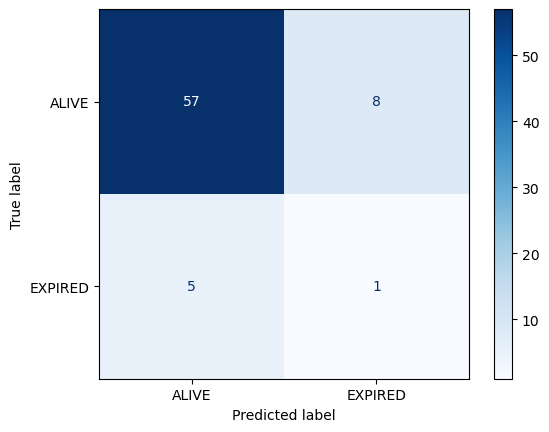

In [26]:
# import the metrics class
from sklearn import metrics

confusion = metrics.confusion_matrix(y_test, y_hat_test)

class_names=cohort['actualhospitalmortality'].cat.categories
disp = metrics.ConfusionMatrixDisplay.from_estimator(
    reg, x_test, y_test, display_labels=class_names,
    cmap=plt.cm.Blues)

plt.show()


### Accuracy

$$ Accuracy=\frac{TP+TN}{TP+TN+FP+FN} $$

In [22]:
acc = metrics.accuracy_score(y_test, y_hat_test)
print(f"Accuracy (model) = {acc:.2f}")

Accuracy (model) = 0.82


In [23]:
zeros = np.zeros(len(y_test))
acc = metrics.accuracy_score(y_test, zeros)
print(f"Accuracy (zeros) = {acc:.2f}")

Accuracy (zeros) = 0.92


### Sensitivity (A.K.A “Recall” and “True Positive Rate”)

$$ Sensitivity=Recall=\frac{TP}{TP+FN} $$

### Specificity (A.K.A “True Negative Rate”)

$$ Specificity=\frac{TN}{FP+TN} $$

### Receiver-Operator Characteristic

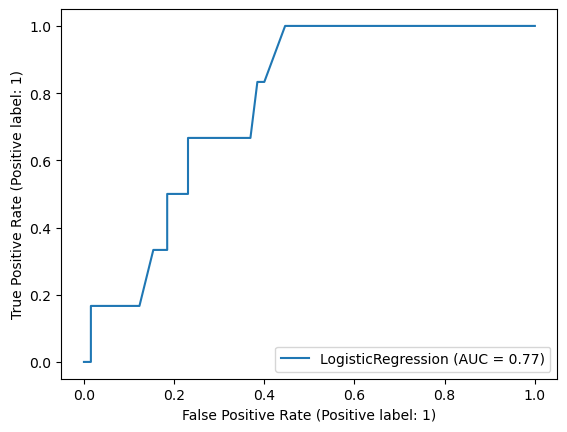

In [33]:
# metrics.plot_roc_curve(reg, x_test, y_test)
metrics.RocCurveDisplay.from_estimator(reg, x_test, y_test)


## Bootstrapping

### Bootstraping

In [34]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import accuracy_score

# convert outcome to a categorical type
categories=['ALIVE', 'EXPIRED']
cohort['actualhospitalmortality'] = pd.Categorical(cohort['actualhospitalmortality'], categories=categories)

# add the encoded value to a new column
cohort['actualhospitalmortality_enc'] = cohort['actualhospitalmortality'].cat.codes
cohort[['actualhospitalmortality_enc','actualhospitalmortality']].head()

# define features and outcome
features = ['apachescore']
outcome = ['actualhospitalmortality_enc']

# partition data into training and test sets
X = cohort[features]
y = cohort[outcome]
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 42)

# restructure data for input into model
# note: remove the reshape if fitting to >1 input variable
x_train = x_train.values.reshape(-1, 1)
y_train = y_train.values.ravel()
x_test = x_test.values.reshape(-1, 1)
y_test = y_test.values.ravel()

# train model
reg = LogisticRegression(random_state=0)
reg.fit(x_train, y_train)

# bootstrap predictions
accuracy = []
n_iterations = 1000
for i in range(n_iterations):
    X_bs, y_bs = resample(x_train, y_train, replace=True)
    # make predictions
    y_hat = reg.predict(X_bs)
    # evaluate model
    score = accuracy_score(y_bs, y_hat)
    accuracy.append(score)

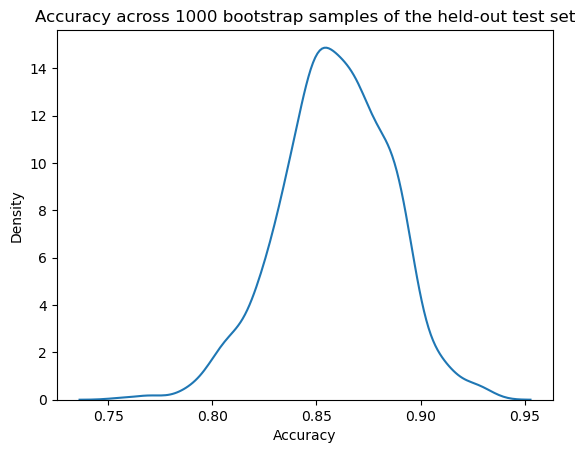

In [35]:
import seaborn as sns
# plot distribution of accuracy
sns.kdeplot(accuracy)
plt.title("Accuracy across 1000 bootstrap samples of the held-out test set")
plt.xlabel("Accuracy")
plt.show()

### Percentile method

In [36]:
# get median
median = np.percentile(accuracy, 50)

# get 95% interval
alpha = 100-95
lower_ci = np.percentile(accuracy, alpha/2)
upper_ci = np.percentile(accuracy, 100-alpha/2)

print(f"Model accuracy is reported on the test set. 1000 bootstrapped samples " 
      f"were used to calculate 95% confidence intervals.\n"
      f"Median accuracy is {median:.2f} with a 95% a confidence "
      f"interval of [{lower_ci:.2f},{upper_ci:.2f}].")

Model accuracy is reported on the test set. 1000 bootstrapped samples were used to calculate 95% confidence intervals.
Median accuracy is 0.86 with a 95% a confidence interval of [0.80,0.91].


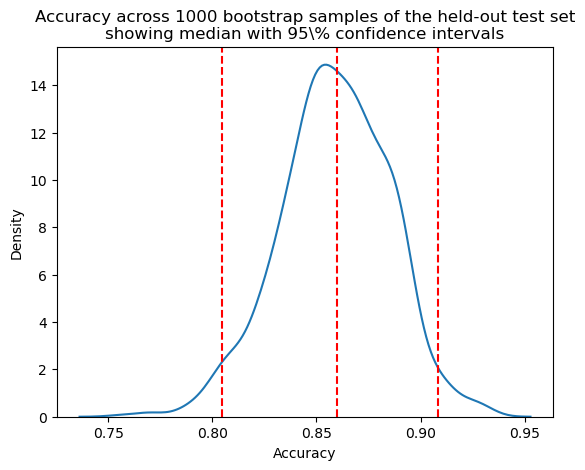

In [37]:
sns.kdeplot(accuracy)
plt.title("Accuracy across 1000 bootstrap samples of the held-out test set\n"
          "showing median with 95\\% confidence intervals")
plt.xlabel("Accuracy")
plt.axvline(median,0, 14, linestyle="--", color="red")
plt.axvline(lower_ci,0, 14, linestyle="--", color="red")
plt.axvline(upper_ci,0, 14, linestyle="--", color="red")
plt.show()

## Data leakage

All text

# Responsible machine learning

Course notes are [here](https://carpentries-incubator.github.io/machine-learning-responsible-python/).

### Setup

This will have to be done as it is not included in this repository

1. Create a subfolder called data.
2. Download eicu_v2_0_1.sqlite3.gz from the Files section of the [project page](https://physionet.org/content/eicu-crd-demo/2.0.1/) (you have to click in the sqlite directory).
3. Move the downloaded file to ml-responsible/data.
4. Unzip the file.

### Introduction

eICU Collaborative Research Database Demo was derived from:
[eICU Collaborative Research Database v2.0](https://physionet.org/content/eicu-crd/2.0/).

The Alan Turing Institute [Understanding artificial intelligence ethics and safety](https://www.turing.ac.uk/sites/default/files/2019-08/understanding_artificial_intelligence_ethics_and_safety.pdf) document (97 pages).

An [ACM 2018 statement](https://web.archive.org/web/20200101022756/https://acm-fca.org/2018/03/29/negativeimpacts/) also given as arxiv [paper](https://arxiv.org/pdf/2112.09544.pdf).

# Tree models

Course notes are [here](https://carpentries-incubator.github.io/machine-learning-trees-python/).

### Setup

Download the [eicu_cohort_trees.csv](https://carpentries-incubator.github.io/machine-learning-trees-python/data/eicu_cohort_trees.csv) file and place with the other data files.


### Loading the patient cohort

In [2]:
# import libraries
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# load the data
cohort = pd.read_csv('./eicu_cohort_trees.csv')

# Display the first 5 rows of the data
cohort.head()

,gender,age,admissionweight,unabridgedhosplos,acutephysiologyscore,apachescore,actualhospitalmortality,heartrate,meanbp,creatinine,temperature,respiratoryrate,wbc,admissionheight
0,Female,48,86.4,27.5583,44,49,ALIVE,102.0,54.0,1.16,36.9,39.0,6.1,177.8
1,Female,59,66.6,15.0778,56,61,ALIVE,134.0,172.0,1.03,34.8,32.0,25.5,170.2
2,Male,31,66.8,2.7326,45,45,ALIVE,138.0,71.0,2.35,37.2,34.0,21.4,188.0
3,Female,51,77.1,0.1986,19,24,ALIVE,122.0,73.0,-1.00,36.8,26.0,-1.0,160.0
4,Female,48,63.4,1.7285,25,30,ALIVE,130.0,68.0,1.10,-1.0,29.0,7.6,172.7


### Preparing for data analysis

In [4]:
# Encode the categorical data
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
cohort['actualhospitalmortality_enc'] = encoder.fit_transform(cohort['actualhospitalmortality'])

In [5]:
# Handle the deidentified ages
cohort['age'] = pd.to_numeric(cohort['age'], downcast='integer', errors='coerce')
cohort['age'] = cohort['age'].fillna(value=91.5)

In [22]:
# Disable FutureWarning messages
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [23]:
from tableone import tableone

t1 = tableone(cohort, groupby='actualhospitalmortality')
#print(t1.tabulate(tablefmt = "github"))
print(t1.tabulate(tablefmt = "fancy_grid"))

╒════════════════════════════════════╤═════════╤═══════════╤══════════════╤══════════════╤══════════════╕
│                                    │         │ Missing   │ Overall      │ ALIVE        │ EXPIRED      │
╞════════════════════════════════════╪═════════╪═══════════╪══════════════╪══════════════╪══════════════╡
│ n                                  │         │           │ 536          │ 488          │ 48           │
├────────────────────────────────────┼─────────┼───────────┼──────────────┼──────────────┼──────────────┤
│ gender, n (%)                      │ Female  │ 0         │ 305 (56.9)   │ 281 (57.6)   │ 24 (50.0)    │
├────────────────────────────────────┼─────────┼───────────┼──────────────┼──────────────┼──────────────┤
│                                    │ Male    │           │ 230 (42.9)   │ 207 (42.4)   │ 23 (47.9)    │
├────────────────────────────────────┼─────────┼───────────┼──────────────┼──────────────┼──────────────┤
│                                    │ Unknown

### Exercise

a) What proportion of patients survived their hospital stay?

b) What is the “apachescore” variable? Hint, see the [Wikipeda entry for the Apache Score](https://en.wikipedia.org/wiki/APACHE_II).

c) What is the average age of patients?

# Suggested changes

* Deploy into the same directory for the courses
* All should probably use the `data` 